In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
from tensorflow import keras
import os
from sklearn import model_selection
from sklearn import utils
from sklearn.metrics import confusion_matrix, roc_curve, RocCurveDisplay, roc_auc_score
from scipy import ndimage
from gc import collect
import matplotlib.pyplot as plt
from collections import Counter
from seaborn import heatmap


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
def get_labels(label_file):
    """lê a tabela com as informações dos pacientes e retorna uma matriz com o ID e as labels"""
    labels = pd.read_csv(label_file)
    cancer_labels = dict()

    for p in labels.index:
        cancer_labels[labels['PatientID'][p]] = [int(labels['Normal'][p]), int(labels['Actionable'][p]), int(labels['Benign'][p]), int(labels['Cancer'][p])]

    return cancer_labels

In [4]:
labels = get_labels('/kaggle/input/labelsssssss/labels.csv')
numbers_per_class = [0, 0, 0, 0]
for i in labels:
    numbers_per_class[np.argmax(labels[i])] += 1

proportion_per_class = [round(number_of_class/sum(numbers_per_class), 2) for number_of_class in numbers_per_class]
proportion_per_class

[0.35, 0.25, 0.23, 0.17]

In [5]:
path = '/kaggle/input/192x256xdepth/'
dirs = os.listdir(path)

X = [path + i for i in os.listdir(path)]
y = [np.argmax(labels[(path+i)[-14:-4]]) for i in os.listdir(path)]

In [6]:
def balancing_batch(X, y, max_value):
    X, y = utils.shuffle(X, y)
    new_X, new_y = [], []
    counter_class_zero = 0
    counter_class_one = 0
    counter_class_two = 0
    counter_class_three = 0

    max_per_class = max_value//4

    for test_x, test_y in zip(X, y):
        if test_y == [1, 0, 0, 0] and counter_class_zero < max_per_class:
            new_X.append(test_x)
            new_y.append(test_y)
            counter_class_zero += 1
        elif test_y == [0, 1, 0, 0] and counter_class_one < max_per_class:
            new_X.append(test_x)
            new_y.append(test_y)
            counter_class_one += 1
        elif test_y == [0, 0, 1, 0] and counter_class_two < max_per_class:
            new_X.append(test_x)
            new_y.append(test_y)
            counter_class_two += 1
        elif test_y == [0, 0, 0, 1] and counter_class_three < max_per_class:
            new_X.append(test_x)
            new_y.append(test_y)
            counter_class_three += 1
    
    return np.array(new_X, dtype='float16'), np.array(new_y, dtype='uint8')

In [7]:
def separate_slices(img):
    'function to separate 2d images of 3d original image'
    slices = []

    for i in range(img.shape[-2]):
        slices.append(np.array(img[:, :, i]))

    slices.append(np.mean(img, axis=-2)) #including mean of slices

    return slices

In [8]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify=y,random_state=42, train_size=0.8)

In [9]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels_dir, batch_size, sub_batch_size, dim_img, training, shuffle=True):
        self.list_IDs = list_IDs # array of strings with original images name with directory
        self.labels = self.__get_labels(labels_dir) #dict with labels of all images
        self.batch_size = batch_size #3d-images per batch
        self.sub_batch_size = sub_batch_size #quantity of sub-images per batch will be choose to train
        self.dim_img = dim_img # tuple with width and height of image like (192, 256)
        self.training = training # true if generator is for training, false if generator is for validation
        self.shuffle = shuffle # true or false to shuffle data after any epochs
        self.on_epoch_end() # call of the function


    def __get_labels(self, label_file):
        'take the dict with labels of images'
        labels = pd.read_csv(label_file)
        cancer_labels = dict()

        for p in labels.index:
            cancer_labels[labels['PatientID'][p]] = [int(labels['Normal'][p]), int(labels['Actionable'][p]), int(labels['Benign'][p]), int(labels['Cancer'][p])]

        return cancer_labels

    def __data_augmentation(self, x):
        'generate variations of images'
        new_images = []
        x = x.astype('float16')
        new_images.append(x)

        x = cv2.flip(x.astype('float32'), 1).astype('float16')

        new_images.append(np.expand_dims(x, -1))

        return utils.shuffle(new_images)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))


    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        if self.training:
            X, y = balancing_batch(X, y, self.sub_batch_size)
            return np.array(X[0:self.sub_batch_size], dtype='float16'), np.array(y[0:self.sub_batch_size], dtype='uint8')
        
        return np.array(X), np.array(y)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'
        X = []
        y = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            prev_len_X = len(X)
            full_image = np.load(ID)
            new_images = separate_slices(full_image)
            if self.training:
                for img in new_images:
                    X += self.__data_augmentation(img)
            else:
                X = np.array(new_images, dtype='float16')

            #adding new data labels for y array
            for _ in range(len(X) - prev_len_X):
                y.append(self.labels[ID[-14:-4]]) #'-14:-4 represent a part of string with name of original image that slices was taken'

        X, y = utils.shuffle(X, y)
        return X, y

In [10]:
class InceptionModule_a(keras.layers.Layer):
    def __init__(self, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get('relu')
        
        self.conv_a1    = keras.layers.Conv2D(64, kernel_size=(1,1), padding='same', strides=1)
        self.bn_a1      = keras.layers.BatchNormalization()
        self.conv_a2    = keras.layers.Conv2D(96, kernel_size=(3,3), padding='same', strides=1)
        self.bn_a2      = keras.layers.BatchNormalization()
        self.conv_a3    = keras.layers.Conv2D(96, kernel_size=(3,3), padding='same', strides=1)
        self.bn_a3      = keras.layers.BatchNormalization()
        
        self.conv_b1    = keras.layers.Conv2D(48, kernel_size=(1, 1), padding='same', strides=1)
        self.conv_b2    = keras.layers.Conv2D(48, kernel_size=(3, 3), padding='same', strides=1)
        self.bn_b1       = keras.layers.BatchNormalization()
        
        self.maxpool_c  = keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same', strides=1)
        self.conv_c1    = keras.layers.Conv2D(32, kernel_size=(1, 1), padding='same', strides=1)
        self.bn_c1      = keras.layers.BatchNormalization()
        
        self.conv_d1    = keras.layers.Conv2D(64, kernel_size=(1, 1), padding='same', strides=1)
        self.bn_d       = keras.layers.BatchNormalization()
        
    def call(self, x):
        out1 = self.conv_a1(x)
        out1 = self.bn_a1(out1)
        out1 = self.conv_a2(out1)
        out1 = self.bn_a2(out1)
        out1 = self.conv_a3(out1)
        out1 = self.bn_a3(out1)
        out1 = self.activation(out1)
        
        out2 = self.conv_b1(x)
        out2 = self.conv_b2(out2)
        out2 = self.bn_b1(out2)
        out2 = self.activation(out2)
        
        out3 = self.maxpool_c(x)
        out3 = self.conv_c1(out3)
        out3 = self.bn_c1(out3)
        out3 = self.activation(out3)
        
        out4 = self.conv_d1(x)
        out4 = self.bn_d(out4)
        out4 = self.activation(out4)
        
        return tf.concat([out1, out2, out3, out4], axis=3)
    
class InceptionReduction_a(keras.layers.Layer):
    def __init__(self, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get('relu')
        
        self.maxpool_a  = keras.layers.MaxPooling2D(pool_size=(2), padding='same')
        
        self.conv_b1 = keras.layers.Conv2D(384, kernel_size=(2, 4), padding='same', strides=2)
        self.bn_b1    = keras.layers.BatchNormalization()
        
        self.conv_c1 = keras.layers.Conv2D(64, kernel_size=(1,1), padding='same')
        self.conv_c2 = keras.layers.Conv2D(96, kernel_size=(2,4), padding='same')
        self.bn_c1   = keras.layers.BatchNormalization()
        self.conv_c3 = keras.layers.Conv2D(96, kernel_size=(2,4), padding='same', strides=2)
        self.bn_c2   = keras.layers.BatchNormalization()
        
    def call(self, x):
        out1 = self.maxpool_a(x)
        out1 = self.activation(out1)
        
        out2 = self.conv_b1(x)
        out2 = self.bn_b1(out2)
        out2 = self.activation(out2)
        
        out3 = self.conv_c1(x)
        out3 = self.conv_c2(out3)
        out3 = self.bn_c1(out3)
        out3 = self.conv_c3(out3)
        out3 = self.bn_c2(out3)
        out3 = self.activation(out3)
        
        return tf.concat([out1, out2, out3], axis=3)

class InceptionModule_b(keras.layers.Layer):
    def __init__(self, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get('relu')
        
        self.conv_a1   = keras.layers.Conv2D(128, kernel_size=(1,1), padding='same', strides=1)
        self.conv_a2   = keras.layers.Conv2D(128, kernel_size=(1,7), padding='same', strides=1)
        self.bn_a1     = keras.layers.BatchNormalization()
        self.conv_a3   = keras.layers.Conv2D(128, kernel_size=(7,1), padding='same', strides=1)
        self.bn_a2     = keras.layers.BatchNormalization()
        self.conv_a4   = keras.layers.Conv2D(128, kernel_size=(1,7), padding='same', strides=1)
        self.bn_a3     = keras.layers.BatchNormalization()
        self.conv_a5   = keras.layers.Conv2D(192, kernel_size=(7,1), padding='same', strides=1)
        self.bn_a4     = keras.layers.BatchNormalization()
        
        self.conv_b1   = keras.layers.Conv2D(128, kernel_size=(1, 1), padding='same', strides=1)
        self.conv_b2   = keras.layers.Conv2D(128, kernel_size=(7, 1), padding='same', strides=1)
        self.bn_b1     = keras.layers.BatchNormalization()
        self.conv_b3   = keras.layers.Conv2D(192, kernel_size=(1, 7), padding='same', strides=1)
        self.bn_b2     = keras.layers.BatchNormalization()
        
        self.maxpool_c = keras.layers.MaxPooling2D(pool_size=(2), padding='same', strides=1)
        self.conv_c1   = keras.layers.Conv2D(192, kernel_size=(1, 1), padding='same', strides=1)
        self.bn_c1     = keras.layers.BatchNormalization()
        
        self.conv_d1    = keras.layers.Conv2D(192, kernel_size=(1, 1), padding='same', strides=1)
        self.bn_d1      = keras.layers.BatchNormalization()
        
    def call(self, x):
        out1 = self.conv_a1(x)
        out1 = self.conv_a2(out1)
        out1 = self.bn_a1(out1)
        out1 = self.conv_a3(out1)
        out1 = self.bn_a2(out1)
        out1 = self.conv_a4(out1)
        out1 = self.bn_a3(out1)
        out1 = self.conv_a5(out1)
        out1 = self.bn_a4(out1)
        out1 = self.activation(out1)
        
        out2 = self.conv_b1(x)
        out2 = self.conv_b2(out2)
        out2 = self.bn_b1(out2)
        out2 = self.conv_b3(out2)
        out2 = self.bn_b2(out2)
        out2 = self.activation(out2)
        
        out3 = self.maxpool_c(x)
        out3 = self.conv_c1(out3)
        out3 = self.bn_c1(out3)
        out4 = self.activation(out3)
        
        out4 = self.conv_d1(x)
        out4 = self.bn_d1(out4)
        out4 = self.activation(out4)
        
        return tf.concat([out1, out2, out3, out4], axis=3)
    
class InceptionReduction_b(keras.layers.Layer):
    def __init__(self, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get('relu')
        
        self.maxpool_a  = keras.layers.MaxPooling2D(pool_size=(2), padding='same', strides=2)
        
        self.conv_b1 = keras.layers.Conv2D(192, kernel_size=(1,1), padding='same')
        self.conv_b2 = keras.layers.Conv2D(320, kernel_size=(2,4), padding='same', strides=2)
        self.bn_b    = keras.layers.BatchNormalization()
        
        self.conv_c1 = keras.layers.Conv2D(192, kernel_size=(1,1), padding='same')
        self.conv_c2 = keras.layers.Conv2D(192, kernel_size=(1,7), padding='same')
        self.bn_c1   = keras.layers.BatchNormalization()
        self.conv_c3 = keras.layers.Conv2D(192, kernel_size=(7,1), padding='same')
        self.bn_c2   = keras.layers.BatchNormalization()
        self.conv_c4 = keras.layers.Conv2D(192, kernel_size=(2, 4), padding='same', strides=2)
        self.bn_c3   = keras.layers.BatchNormalization()
        
    def call(self, x):
        out1 = self.maxpool_a(x)
        out1 = self.activation(out1)
        
        out2 = self.conv_b1(x)
        out2 = self.conv_b2(out2)
        out2 = self.bn_b(out2)
        out2 = self.activation(out2)
        
        out3 = self.conv_c1(x)
        out3 = self.conv_c2(out3)
        out3 = self.bn_c1(out3)
        out3 = self.conv_c3(out3)
        out3 = self.bn_c2(out3)
        out3 = self.conv_c4(out3)
        out3 = self.bn_c3(out3)
        out3 = self.activation(out3)
        
        return tf.concat([out1, out2, out3], axis=3)
    
class InceptionModule_c(keras.layers.Layer):
    def __init__(self, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get('relu')
        
        self.conv_a1   = keras.layers.Conv2D(192, kernel_size=(1,1), padding='same')
        self.conv_a2   = keras.layers.Conv2D(192, kernel_size=(3,3), padding='same')
        self.bn_a1     = keras.layers.BatchNormalization()
        self.conv_a11  = keras.layers.Conv2D(192, kernel_size=(1,3), padding='same', strides=2)
        self.bn_a11    = keras.layers.BatchNormalization()
        self.conv_a12  = keras.layers.Conv2D(192, kernel_size=(3,1), padding='same',strides=2)
        self.bn_a12    = keras.layers.BatchNormalization()
        
        self.conv_a1   = keras.layers.Conv2D(192, kernel_size=(1,1), padding='same')
        self.bn_a1     = keras.layers.BatchNormalization()
        self.conv_a11  = keras.layers.Conv2D(192, kernel_size=(1,3), padding='same', strides=2)
        self.bn_a11    = keras.layers.BatchNormalization()
        self.conv_a12  = keras.layers.Conv2D(192, kernel_size=(3,1), padding='same', strides=2)
        self.bn_a12    = keras.layers.BatchNormalization()
        
        self.maxpool_c = keras.layers.MaxPooling2D(pool_size=(2), padding='same')
        self.conv_c1   = keras.layers.Conv2D(192, kernel_size=(1, 1), padding='same')
        self.bn_c      = keras.layers.BatchNormalization()
        
        self.conv_d    = keras.layers.Conv2D(384, kernel_size=(1, 1), padding='same', strides=2)
        self.bn_d      = keras.layers.BatchNormalization()
        
    def call(self, x):
        out1  = self.conv_a1(x)
        out1  = self.conv_a2(out1)
        out1  = self.bn_a1(out1)
        out11 = self.conv_a11(out1)
        out11 = self.bn_a11(out11)
        out11 = self.activation(out11)
        out12 = self.conv_a12(out1)
        out12 = self.bn_a12(out12)
        out11 = self.activation(out12)
        
        out2 = self.conv_a1(x)
        out2 = self.bn_a1(out2)
        out21 = self.conv_a11(out2)
        out21 = self.bn_a11(out21)
        out21 = self.activation(out21)
        out22 = self.conv_a12(out2)
        out22 = self.bn_a12(out22)
        out22 = self.activation(out22)
        
        out3 = self.maxpool_c(x)
        out3 = self.conv_c1(out3)
        out3 = self.bn_c(out3)
        out3 = self.activation(out3)
        
        out4 = self.conv_d(x)
        out4 = self.bn_d(out4)
        out4 = self.activation(out4)
        
        return tf.concat([out11, out12, out21, out22, out3, out4], axis=3)

def get_inception_v3():
    Inception_v3 = keras.Sequential()
    Inception_v3.add(keras.layers.Conv2D(filters=32, kernel_size=(4,2), padding='valid', strides=2, input_shape=(192, 256, 1)))
    Inception_v3.add(keras.layers.BatchNormalization())
    Inception_v3.add(keras.layers.Conv2D(filters=32, kernel_size=(4,2), padding='valid', strides=1))
    Inception_v3.add(keras.layers.BatchNormalization())
    Inception_v3.add(keras.layers.Conv2D(filters=64, kernel_size=(4,2), padding='same', strides=1))
    Inception_v3.add(keras.layers.BatchNormalization())
    Inception_v3.add(keras.layers.MaxPooling2D(2))
    Inception_v3.add(keras.layers.Conv2D(filters=80, kernel_size=(4,2), padding='valid', strides=1))
    Inception_v3.add(keras.layers.BatchNormalization())
    Inception_v3.add(keras.layers.Conv2D(filters=192, kernel_size=(4,2), padding='valid', strides=2))
    Inception_v3.add(keras.layers.BatchNormalization())
    Inception_v3.add(InceptionModule_a())
    Inception_v3.add(InceptionModule_a())
    Inception_v3.add(InceptionModule_a())
    Inception_v3.add(InceptionReduction_a())
    Inception_v3.add(InceptionModule_b())
    Inception_v3.add(InceptionModule_b())
    Inception_v3.add(InceptionModule_b())
    Inception_v3.add(InceptionModule_b())
    Inception_v3.add(InceptionModule_b())
    Inception_v3.add(InceptionReduction_b())
    Inception_v3.add(InceptionModule_c())
    Inception_v3.add(InceptionModule_c())
    Inception_v3.add(keras.layers.GlobalAveragePooling2D())
    Inception_v3.add(keras.layers.Dense(2048, activation='relu'))
    Inception_v3.add(keras.layers.Dense(4, activation='sigmoid'))
    
    return Inception_v3

In [10]:
checkpoint_callback_auc1 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/auc1/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_1',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc2 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/auc2/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_2',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc3 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/auc3/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_3',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc4 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/auc4/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_4',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc5 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/auc5/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_5',
                                                             mode='max',
                                                             save_best_only=True)

callbacks_list = [checkpoint_callback_auc1,
                  checkpoint_callback_auc2,
                  checkpoint_callback_auc3,
                  checkpoint_callback_auc4,
                  checkpoint_callback_auc5]

def lr_scheduler(epoch, lr):
    return lr*0.9

lr_decay_function = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=0)

In [12]:
histories = []
n_splits = 5
skf = model_selection.StratifiedShuffleSplit(n_splits=n_splits, random_state=314, train_size=0.85)
for number_of_split, data in enumerate(skf.split(X_train, y_train)):
    print(f'SPLIT {number_of_split+1}/{n_splits}:')
    train = [path + dirs[i] for i in data[0]]
    val = [path + dirs[j] for j in data[1]]

    # Generators
    training_generator = DataGenerator(list_IDs=train,
                                       labels_dir='/kaggle/input/labelsssssss/labels.csv',
                                       dim_img=(192, 256),
                                       batch_size=5,
                                       sub_batch_size=200,
                                       shuffle=True,
                                       training=True)

    validation_generator = DataGenerator(list_IDs=val,
                                         labels_dir='/kaggle/input/labelsssssss/labels.csv',
                                         dim_img=(192, 256),
                                         batch_size=1,
                                         sub_batch_size='IGNORED', #this argument will be ignored because training is false.
                                         shuffle=True,
                                         training=False)

    inception = get_inception_v3()

    inception.compile(loss='categorical_crossentropy',
                     optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                     metrics=[keras.metrics.AUC(name=f'AUC_{number_of_split+1}'),
                              keras.metrics.Accuracy(name='accuracy'),
                              keras.metrics.Precision(name='precision'),
                              keras.metrics.Recall(name='recall')])


    # Train model on dataset
    histories.append(inception.fit(training_generator,
                                   validation_data=validation_generator,
                                   epochs=50,
                                   use_multiprocessing=True,
                                   workers=1,
                                   callbacks=[callbacks_list[number_of_split], lr_decay_function]))
    print('\n')
    collect()

SPLIT 1/5:
Epoch 1/50
29/29 [==============================] - 187s 3s/step - loss: 1.6124 - AUC_1: 0.5242 - accuracy: 0.0000e+00 - precision: 0.2625 - recall: 0.5724 - val_loss: 1.3452 - val_AUC_1: 0.6183 - val_accuracy: 0.0000e+00 - val_precision: 0.3433 - val_recall: 0.6866 - lr: 9.0000e-05
Epoch 2/50
29/29 [==============================] - 70s 2s/step - loss: 1.3186 - AUC_1: 0.6597 - accuracy: 0.0000e+00 - precision: 0.3428 - recall: 0.6713 - val_loss: 1.4032 - val_AUC_1: 0.4621 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 8.1000e-05
Epoch 3/50
29/29 [==============================] - 71s 2s/step - loss: 1.1107 - AUC_1: 0.7600 - accuracy: 0.0000e+00 - precision: 0.3935 - recall: 0.7621 - val_loss: 1.3737 - val_AUC_1: 0.6111 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 7.2900e-05
Epoch 4/50
29/29 [==============================] - 70s 2s/step - loss: 0.9436 - AUC_1: 0.8354 - accuracy: 0.0000e+00 - pre

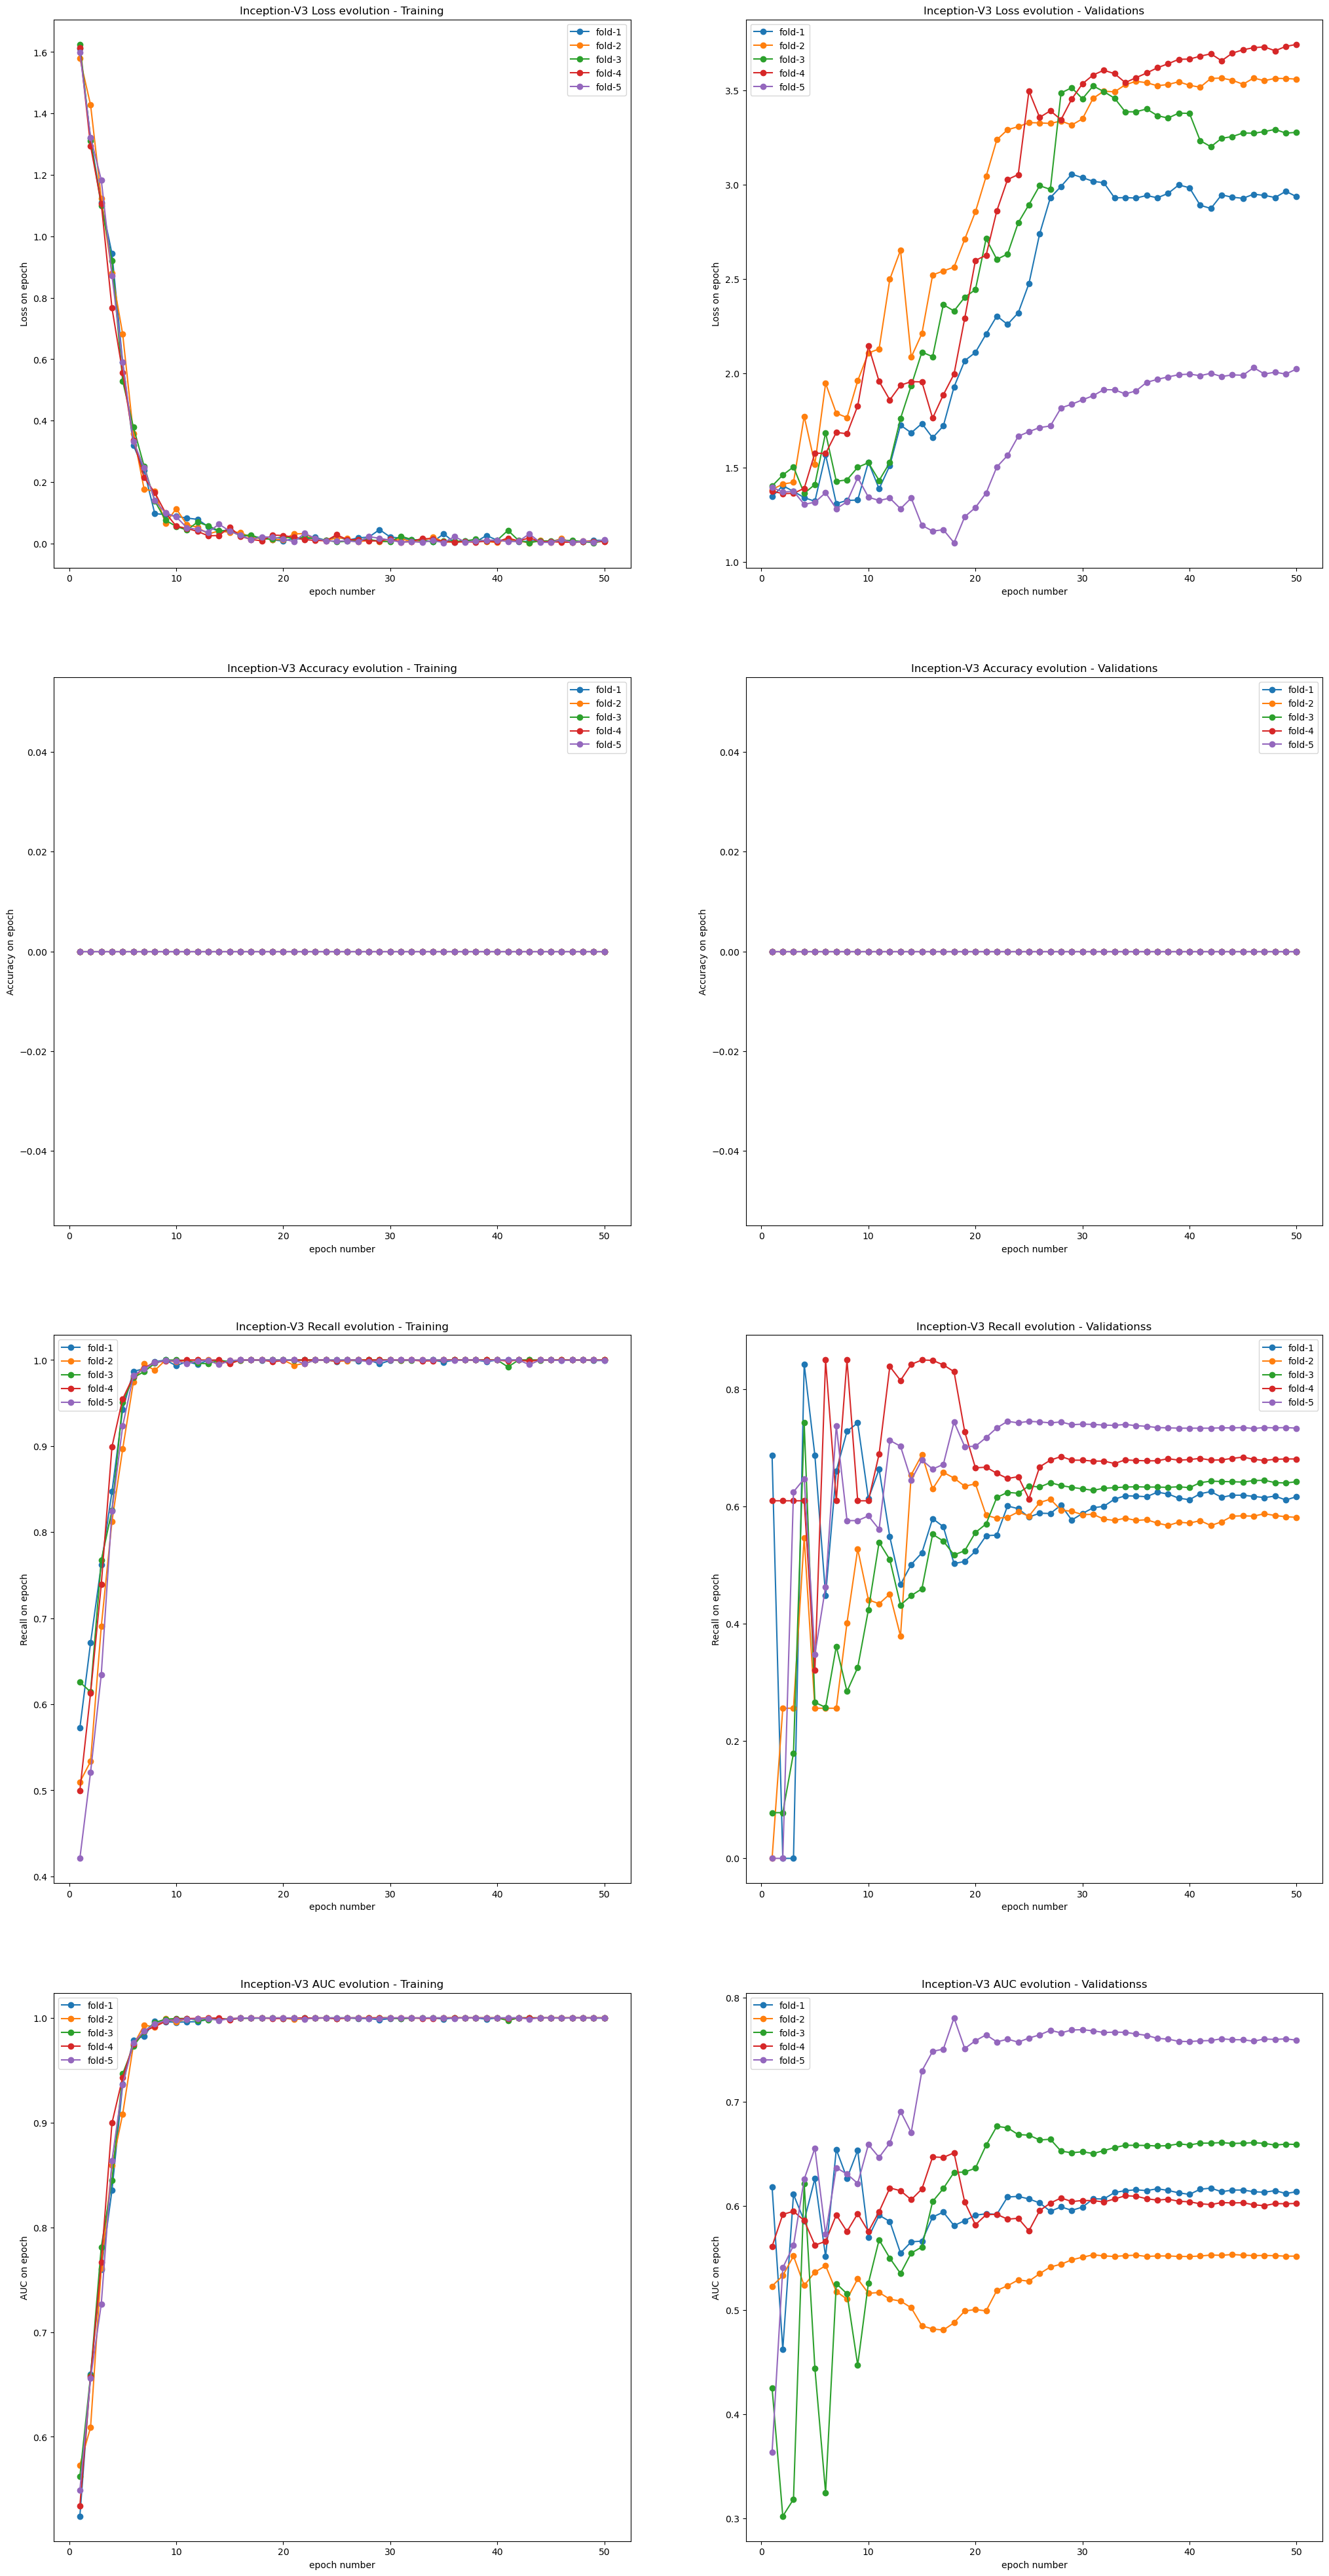

In [13]:
plt.figure(figsize=(25, 50))
plt.subplot(4, 2, 1)
for i, h in enumerate(histories):
    plt.plot(list(range(1, 51)), h.history['loss'], marker='o')
    plt.title('Inception-V3 Loss evolution - Training')
    plt.xlabel('epoch number')
    plt.ylabel('Loss on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 2)
for i, h in enumerate(histories):
    plt.plot(list(range(1, 51)), h.history['val_loss'], marker='o')
    plt.title('Inception-V3 Loss evolution - Validations')
    plt.xlabel('epoch number')
    plt.ylabel('Loss on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 3)
for i, h in enumerate(histories):
    plt.plot(list(range(1, 51)), h.history['accuracy'], marker='o')
    plt.title('Inception-V3 Accuracy evolution - Training')
    plt.xlabel('epoch number')
    plt.ylabel('Accuracy on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 4)
for i, h in enumerate(histories):
    plt.plot(list(range(1, 51)), h.history['val_accuracy'], marker='o')
    plt.title('Inception-V3 Accuracy evolution - Validations')
    plt.xlabel('epoch number')
    plt.ylabel('Accuracy on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 5)
for i, h in enumerate(histories):
    plt.plot(list(range(1, 51)), h.history['recall'], marker='o')
    plt.title('Inception-V3 Recall evolution - Training')
    plt.xlabel('epoch number')
    plt.ylabel('Recall on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 6)
for i, h in enumerate(histories):
    plt.plot(list(range(1, 51)), h.history['val_recall'], marker='o')
    plt.title('Inception-V3 Recall evolution - Validationss')
    plt.xlabel('epoch number')
    plt.ylabel('Recall on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 7)
for i, h in enumerate(histories):
    key_auc = f"AUC_{i+1}"
    plt.plot(list(range(1, 51)), h.history[key_auc], marker='o')
    plt.title('Inception-V3 AUC evolution - Training')
    plt.xlabel('epoch number')
    plt.ylabel('AUC on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 8)
for i, h in enumerate(histories):
    key_auc_val = f"val_AUC_{i+1}"
    plt.plot(list(range(1, 51)), h.history[key_auc_val], marker='o')
    plt.title('Inception-V3 AUC evolution - Validationss')
    plt.xlabel('epoch number')
    plt.ylabel('AUC on epoch')
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

In [14]:
print('Best results in validations for any k-fold: ')
for i, h in enumerate(histories):
    print(f'K-FOLD {i+1}:')
    print("TRAINING RESULTS:")
    k = np.max(h.history[f'AUC_{i+1}'])
    print(f'Best AUC in train: {k}')
    k = np.max(h.history[f'accuracy'])
    print(f'Best Accuracy in train: {k}')
    k = np.max(h.history[f'precision'])
    print(f'Best Precision in train: {k}')
    k = np.max(h.history[f'recall'])
    print(f'Best Recall in train: {k}')

    print("\nVALIDATION RESULTS:")
    k = np.max(h.history[f'val_AUC_{i+1}'])
    print(f'Best AUC in validation: {k}')
    k = np.max(h.history[f'val_accuracy'])
    print(f'Best Accuracy in validation: {k}')
    k = np.max(h.history[f'val_precision'])
    print(f'Best Precision in validation: {k}')
    k = np.max(h.history[f'val_recall'])
    print(f'Best Recall in validation: {k}')
    print()
    print(f'{50*"="}')
    print()

results = np.empty((4, 5))
for i, h in enumerate(histories):
    results[0][i] = np.max(h.history[f'val_AUC_{i+1}'])
    results[1][i] = np.max(h.history['val_accuracy'])
    results[2][i] = np.max(h.history['val_precision'])
    results[3][i] = np.max(h.history['val_recall'])

print(f"Average best AUC: {np.mean(results[0])}")
print(f"standard deviation AUC: {np.std(results[0])}\n")
print(f"Average best Accuracy: {np.mean(results[1])}")
print(f"Standard Deviation Accuracy: {np.std(results[1])}\n")
print(f"Average best Precision: {np.mean(results[2])}")
print(f"Standard Deviation Precision: {np.std(results[2])}\n")
print(f"Average best Recall: {np.mean(results[3])}")
print(f"Standard Deviation Recall: {np.std(results[3])}\n")

Best results in validations for any k-fold: 
K-FOLD 1:
TRAINING RESULTS:
Best AUC in train: 0.9999984502792358
Best Accuracy in train: 0.0
Best Precision in train: 0.775460958480835
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.6542890667915344
Best Accuracy in validation: 0.0
Best Precision in validation: 0.3433026671409607
Best Recall in validation: 0.8425357937812805


K-FOLD 2:
TRAINING RESULTS:
Best AUC in train: 0.9999998211860657
Best Accuracy in train: 0.0
Best Precision in train: 0.8381924033164978
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.5533971786499023
Best Accuracy in validation: 0.0
Best Precision in validation: 0.2972423732280731
Best Recall in validation: 0.6879505515098572


K-FOLD 3:
TRAINING RESULTS:
Best AUC in train: 0.9999985694885254
Best Accuracy in train: 0.0
Best Precision in train: 0.8060134053230286
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.6765021681785583
Best Accurac

**TESTS**

In [11]:
training_generator = DataGenerator(list_IDs=X_train,
                                   labels_dir='/kaggle/input/labelsssssss/labels.csv',
                                   dim_img=(192, 256),
                                   batch_size=5,
                                   sub_batch_size=400,
                                   shuffle=True,
                                   training=True)

inception = get_inception_v3()

inception.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(1e-7),
                  metrics=[keras.metrics.AUC(name='AUC'),
                           keras.metrics.Accuracy(name='accuracy'),
                           keras.metrics.Precision(name='precision'),
                           keras.metrics.Recall(name='recall')])


# Train model on dataset
inception.load_weights('/kaggle/working/models/auc5/') #start with best AUC in validations
history = inception.fit(training_generator, epochs=5)

Epoch 1/5
35/35 [==============================] - 1825s 51s/step - loss: 0.7181 - AUC: 0.9339 - accuracy: 0.0000e+00 - precision: 0.6078 - recall: 0.9137
Epoch 2/5
35/35 [==============================] - 1795s 51s/step - loss: 0.3199 - AUC: 0.9713 - accuracy: 0.0000e+00 - precision: 0.5911 - recall: 0.9600
Epoch 3/5
35/35 [==============================] - 1838s 53s/step - loss: 0.1147 - AUC: 0.9958 - accuracy: 0.0000e+00 - precision: 0.6922 - recall: 0.9968
Epoch 4/5
35/35 [==============================] - 1738s 50s/step - loss: 0.0864 - AUC: 0.9975 - accuracy: 0.0000e+00 - precision: 0.7327 - recall: 0.9990
Epoch 5/5
35/35 [==============================] - 1836s 53s/step - loss: 0.0504 - AUC: 0.9991 - accuracy: 0.0000e+00 - precision: 0.7413 - recall: 0.9998


In [12]:
res = []
for x in X_test:
    x = np.load(x)
    x = np.array(separate_slices(x))
    pred = inception.predict(np.array(x), verbose=0)
    pred = pred.sum(axis=0)
    res.append(np.argmax(pred))

In [13]:
matrix_confusion = np.array([[0, 0, 0, 0],
                             [0, 0, 0, 0],
                             [0, 0, 0, 0],
                             [0, 0, 0, 0]])

for y_pred, y_true in zip(res, y_test):
    matrix_confusion[y_pred][y_true] += 1

print(matrix_confusion)

[[13  1  3  0]
 [ 3 11  0  2]
 [ 0  0  8  0]
 [ 0  0  0  4]]
